Welcome. This is a chill notebook for using BKA. We'll help you FM your companion and run an MCMC to fit the cleanest FM we can manage. Let's get to it.

First we need to make a forward model and KLIP our data.

In [1]:
import os
import time
import pickle
import numpy as np
import astropy.io.fits as fits
import pyklip.fitpsf as fitpsf
import matplotlib.pylab as plt
import pyklip.instruments.MagAO as MagAO
from forwardModel import forwardModel

def create_circular_mask(h, w, center=None, radius=None, leq=False):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    if leq is False:
        return dist_from_center >= radius
    else:
        return dist_from_center <= radius

def domask(img, inn=70, outt=180):
    outermask = create_circular_mask(451, 451, radius=outt, leq=True)
    img[~outermask] = np.nanmedian(img)
    mask = create_circular_mask(451, 451, radius=inn)
    masked_img = img.copy()
    masked_img[~mask] = np.nanmedian(img)
    return masked_img

In [2]:
# dataset
date = '16May15'
prefixes = ['Cont_90pct', 'Ha_90pct']
filepaths = []
outputdirs = []
for pref in prefixes:
    filepath = f'data\\{date}\\{pref}\\*fits'
    outputdir = f'output\\{date}\\{pref}'
    filepaths.append(filepath)
    outputdirs.append(outputdir)
# parameters
KLmode = 20
sep = 10
pa = 110
contrast = 1e-2
an = [4,20]
an2 = [4,24]
move = 1
scale = 1
PSFpath = 'doMoffat'
FWHM = 3.73
cores = 4
highpass = 1.5*FWHM
numbasis = 20
smooth = 1

In [3]:
import pandas as pd

export_data = pd.DataFrame(index=[prefix for prefix in prefixes], columns=['Sep (mas)', 'Sep err (mas)', 'PA (deg)', 'PA err (deg)', 'RAoff (mas)', 'RAoff err (mas)', 'Decoff (mas)', 'Decoff err (mas)', 'Sep raw', 'Sep err raw', 'PA raw', 'PA err raw', 'Raw flux (contrast)', 'Raw flux err (contrast)', 'KL', 'movement', 'annuli'])

reading data, num files:  120
Parameters set, ready to begin forward modeling... 
saving files to: .\output\16May15\Cont_90pct
read fits file into data
created median
Calculated ghost center is 148.27761388834494 at x=382 , y=218
returning
Parameter('x_0', value=17.0)
CUT MOF FWHM IS 3.737383177570093
CUT GAU FWHM IS 6.146841405218972 7.466180837533245
FIXED MOFFAT FWHM IS 3.737383177570093
x center is Parameter('x_0', value=15.225012229620855)
y center is Parameter('y_0', value=14.59270244599193)
Parameter('x_0', value=15.225012229620855) Parameter('y_0', value=14.59270244599193)
shift number 0
shift number 100
created median after shifting
Calculated ghost center is 152.06711082937588 at x=382 , y=218
returning
instrumental PSF FWHM is: 3.737383177570093
fm_class ready for KLIP
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 1206.3715789784806 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
Firs

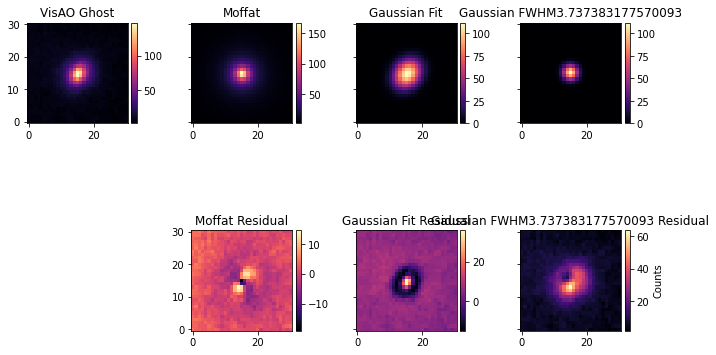

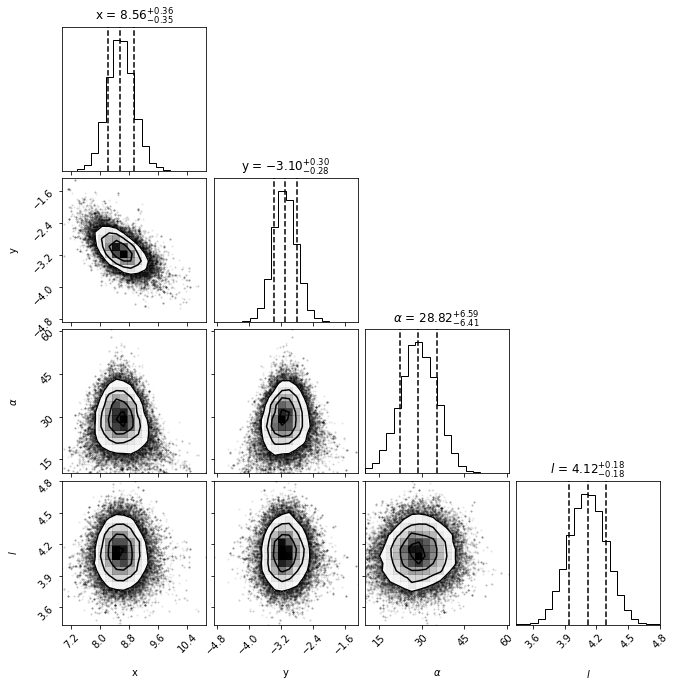

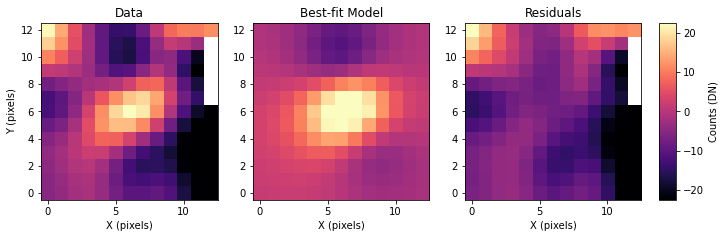

reading data, num files:  117
Parameters set, ready to begin forward modeling... 
saving files to: .\output\16May15\Ha_90pct
read fits file into data
created median
Calculated ghost center is 185.572799780125 at x=382 , y=218
returning
Parameter('x_0', value=17.0)
CUT MOF FWHM IS 3.7551401869158876
CUT GAU FWHM IS 6.982773483904433 6.131823176038433
FIXED MOFFAT FWHM IS 3.7551401869158876
x center is Parameter('x_0', value=15.257871412795884)
y center is Parameter('y_0', value=14.973917924932996)
Parameter('x_0', value=15.257871412795884) Parameter('y_0', value=14.973917924932996)
shift number 0
shift number 100
created median after shifting
Calculated ghost center is 187.05222608354475 at x=382 , y=218
returning
instrumental PSF FWHM is: 3.7551401869158876
fm_class ready for KLIP
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 1206.3715789784806 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
Fir

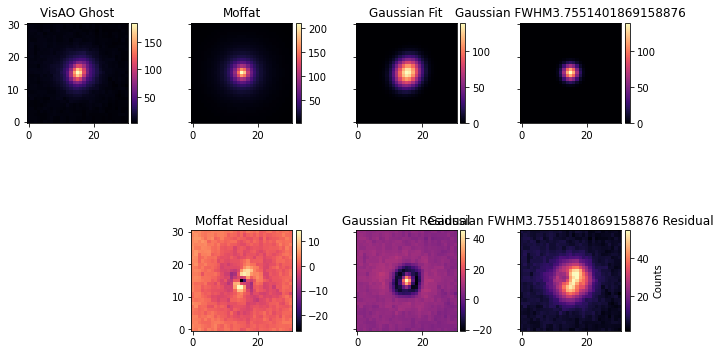

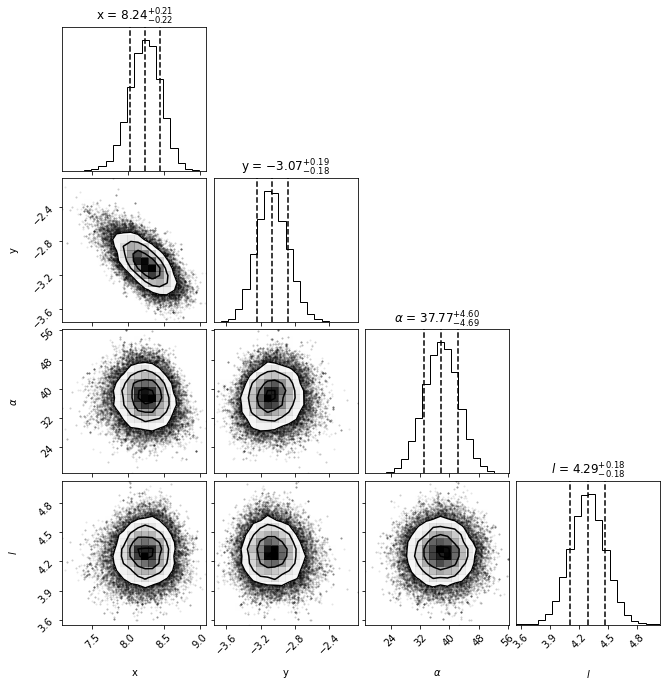

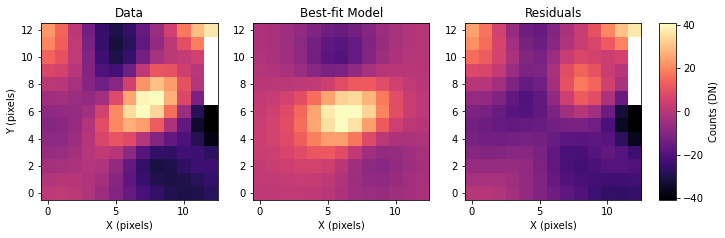

In [4]:
# run
for i in range(len(filepaths)):
    filepath = filepaths[i]
    outputdir = outputdirs[i]
    prefix = prefixes[i]
    fm = forwardModel(filepath, outputdir, prefix, KLmode, sep, pa, contrast, an, move, scale, ePSF=PSFpath, FWHM=FWHM, cores=cores, highpass=highpass, numbasis=numbasis)
    fm.prep_KLIP()
    fm.run_KLIP()
    # Your variables here
    # some basics to point towards your model
    sep = sep # only needs a guess
    pa = pa # guess here too
    length = 2.5 # guess here also

    # set some boundaries for your MCMC
    x_range = 2.5  # in pixels, anywhere from 1.5-5 is reasonable
    y_range = 2.5  # same as x
    flux_range = [10,100] # flux can vary by an order of magnitude
    corr_len_range = 3 # between 0.3 and 30

    # and finally some parameters for the MCMC run
    nwalkers = 8

    nburn = 1000
    nsteps = 10000

    # output to save chain to
    pklout = outputdir+'\\'+prefix+'_chain.pkl'
    
    output_prefix = os.path.join(outputdir, prefix)

    if smooth:
        from pyklip.klip import nan_gaussian_filter
        fm_frame = nan_gaussian_filter(fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0], smooth)
        data_frame = nan_gaussian_filter(fits.getdata(output_prefix + "-klipped-KLmodes-all.fits")[0], smooth)
    else:
        fm_frame = fits.getdata(output_prefix + "-fmpsf-KLmodes-all.fits")[0]
        data_frame = fits.getdata(output_prefix + "-klipped-KLmodes-all.fits")[0]


    fm_header = fits.getheader(output_prefix + "-fmpsf-KLmodes-all.fits")
    fm_centx = fm_header['PSFCENTX']
    fm_centy = fm_header['PSFCENTY']

    data_header = fits.getheader(output_prefix + "-klipped-KLmodes-all.fits")
    data_centx = data_header['PSFCENTX']
    data_centy = data_header['PSFCENTY']

    # get initial guesses. Should be in the header but aren't?
    guesssep = sep
    guesspa = pa

    # create FM Astrometry object - 13 is fitboxsize
    fma = fitpsf.FMAstrometry(guesssep, guesspa, 13)

    # generate FM stamp
    # padding should be greater than 0 so we don't run into interpolation problems
    fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

    # generate data_stamp stamp
    # note that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
    # exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
    fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=3)

    # set kernel, no read noise
    corr_len_guess = length
    corr_len_label = r"$l$"
    fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

    # set bounds based on given boundaries
    fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])
    
    t0 = time.time()

    # run MCMC fit
    fma.fit_astrometry(nwalkers=nwalkers, nburn=nburn, nsteps=nsteps, numthreads=4, chain_output=pklout)

    t1 = time.time()
    print("time taken: ", str(np.round(t1-t0)), " seconds")
    
    platescale=7.95
    platescale_err=0.10
    pa_offset=-0.497
    pa_uncertainty=0.192
    fma.propogate_errs(star_center_err=0.1, platescale=platescale, platescale_err=platescale_err, pa_offset=pa_offset, pa_uncertainty=pa_uncertainty)

    export_data.loc[prefix] = [fma.sep.bestfit,fma.sep.error,fma.PA.bestfit,fma.PA.error,fma.RA_offset.bestfit,
                    fma.RA_offset.error,fma.Dec_offset.bestfit,fma.Dec_offset.error,fma.raw_sep.bestfit,
                    fma.raw_sep.error,fma.raw_PA.bestfit,fma.raw_PA.error,fma.raw_flux.bestfit,
                    fma.raw_flux.error,KLmode,move,an]
    
    fig = fma.make_corner_plot()
    plt.savefig(outputdir+"/"+prefix+'_BKA_corner'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
    plt.show()
    
    fig, resids = fma.best_fit_and_residuals()
    plt.savefig(outputdir+"/"+prefix+'_BKA_residuals'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)
    plt.show()
    
    
    

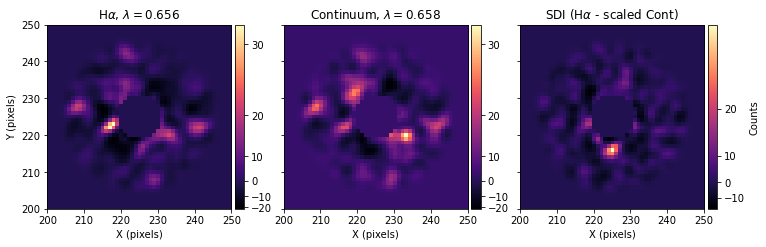

In [5]:
line = fits.getdata(outputdirs[1]+'\\'+prefixes[1]+'-klipped-KLmodes-all.fits')[0]
cont = fits.getdata(outputdirs[0]+'\\'+prefixes[0]+'-klipped-KLmodes-all.fits')[0]

line[np.isnan(line)] = np.nanmedian(line)
cont[np.isnan(cont)] = np.nanmedian(cont)

inner = 6

line = domask(nan_gaussian_filter(line, 1), inn=inner)
cont = domask(nan_gaussian_filter(cont, 1), inn=inner)

scale = 1.2

n2 = line.max()

import matplotlib
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch, SinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

fig = plt.figure(figsize=(12, 4))

# make residual map
residual_map = (line)-(cont*scale)
residual_map = residual_map#/np.nanstd(residual_map)

# normalize all images to same scale
colornorm = matplotlib.colors.Normalize(vmin=np.nanpercentile(line, 0.03),
                                        vmax=np.nanpercentile(line, 99.7))

# plot the data_stamp
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(line, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))
ax1.invert_yaxis()
ax1.set_title(r"H$\alpha$, $\lambda=0.656$")
ax1.set_xlabel("X (pixels)")
ax1.set_ylabel("Y (pixels)")
ax1.set_xlim(200,250)
ax1.set_ylim(200,250)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(im1, cax=cax1)#, ticks=[-500, 0, 500])

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(cont, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))
ax2.invert_yaxis()
ax2.set(yticklabels=[])
ax2.set_title(r"Continuum, $\lambda=0.658$")
ax2.set_xlabel("X (pixels)")
ax2.set_xlim(200,250)
ax2.set_ylim(200,250)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cb2 = fig.colorbar(im1, cax=cax2)#, ticks=[-500, 0, 500])

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(residual_map, interpolation='nearest', cmap='magma', norm=ImageNormalize(stretch=SinhStretch()))#, vmin=-n2, vmax=n2)
ax3.invert_yaxis()
ax3.set(yticklabels=[])
ax3.set_title(r"SDI (H$\alpha$ - scaled Cont)")
ax3.set_xlabel("X (pixels)")
ax3.set_xlim(200,250)
ax3.set_ylim(200,250)

divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="5%", pad=0.05)
cb3 = fig.colorbar(im3, cax=cax3)#, ticks=[-n2, 0, n2])
cb3.set_label("Counts")

plt.savefig(outputdir+'\\SDI'+PSFpath.replace('do',str(FWHM))+'.png', transparent=True, dpi=300)

In [6]:
export_data

,Sep (mas),Sep err (mas),PA (deg),PA err (deg),RAoff (mas),RAoff err (mas),Decoff (mas),Decoff err (mas),Sep raw,Sep err raw,PA raw,PA err raw,Raw flux (contrast),Raw flux err (contrast),KL,movement,annuli
Cont_90pct,72.375132,3.400034,109.374899,1.557197,68.249679,3.073463,-24.054123,2.449174,9.10379,0.399737,109.871899,1.411263,28.824473,6.499691,20,1,"[4, 20]"
Ha_90pct,69.896119,2.29687,109.915995,1.115206,65.705578,2.067313,-23.8171,1.702713,8.791965,0.247441,110.412995,0.884229,37.77301,4.646886,20,1,"[4, 20]"


In [9]:
fm_bestfit = fma.data_stamp
snr = np.nanmax(fm_bestfit)/np.nanstd(resids)

In [10]:
snr

2.335811602914781

In [11]:
np.nanstd(resids)

13.697812529853806